# 目的
OHLCとcross pointおよびその後の勢いとの相関を解析する。   
その解析結果をもとに、確実に利益の最小値がプラスになるスキームを構築する。

# 前回までのまとめ
`analysis of ohlc (201807-201811).ipynb`、`analysis of ohlc (20181224-20181231).ipynb`での解析の結果をまとめると次のようになる。

* Dead crossとgolden crossの両方とも、その前のいくつかのOHLCを見たときに現れないパターンがある。
* 平均的には、cross pointが現れたOHLCの直後にエントリーをすると、EMA(N=5,20)の差が最大または最小となる点において約定すると、dead crossの後は1000程度、golden crossの後は500~1000程度の利益が見込まれる。
* 約定のタイミングが最大・最小となる点より一つずれると、どちらも利益が下がるものの平均的には利確になりうる。
* したがってcross pointが現れたときに、見込みのあるパターンが形成されているならば出現直後にエントリーして、EMAの差が最大または最小となる点（利確点と呼ぶことにする）の前後で約定することで利益を得られそうである。
    + しかし利確点を狙い撃ちするにはまだ情報が足りない。
* 最初の最大・最小点を狙うと、順張りでは利益の最小値がマイナス、逆張りでは確実にマイナスになる。
* 以上から、別のスキームを探索する必要がある。


## このノートで調査する内容
* N1, N2を変え、最も利益の出る組み合わせを探す。

## モジュールと関数の用意

In [1]:
from datetime import datetime
import glob
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pickle

%matplotlib inline

In [2]:
from scipy.signal import lfilter

def calc_EMA(x, N=5):
    """calc_EMA(x, N) -> array-like
    calculate exponential moving average (EMA)
    
    Parameters
    ----------
    x : array-like
        target data series
    N : int (default : 5)
        step for EMA
    
    Returns
    -------
    EMA : array-like
    """
    return _calc_EMA(x, 2./(N + 1.))

def _calc_EMA(x, alpha):
    """ _calc_EMA(x, alpha) -> array-like
    calculate exponential moving average (EMA)
    Adopted from https://qiita.com/toyolab/items/6872b32d9fa1763345d8
    
    Parameters
    ----------
    x : array-like
        target data series
    alpha : float
        characteristic parameter
    
    Returns
    -------
    EMA : array-like
    """
    y,_ = lfilter([alpha], [1,alpha-1], x, zi=[x[0]*(1-alpha)])
    return y

def calc_SMA(df, key="Close", N=5):
    """calc_SMA(df, key="Close", N=5) -> numpy.1darray
    calculate simple moving average (SMA)
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe including target data
    key : str (default : 'Close')
        key to the target data
    N : int (default : 5)
        step for SMA
    
    Returns
    -------
    SMA : numpy.1darray
    """
    return df[key].rolling(5).mean().values

def find_cross_points(y1, y2=None):
    """find_cross_points(y1, y2=None) -> numpy.1darray
    find cross points between two data sequences
    If y2 == None, then find the root of y1.
    
    Parameters
    ----------
    y1 : list or numpy.1darray
    y2 : list or numpy.1darray
    
    Returns
    -------
    cross_points : numpy.1darray
    """
    if y2 is None:
        y2 = np.zeros_like(y1)
    if isinstance(y1, list):
        y1 = np.array(y1)
    if isinstance(y2, list):
        y2 = np.array(y2)
    cross_points = np.zeros(len(y1))
    for ii in range(1, len(y1)):
        if y1[ii - 1] >= y2[ii - 1] and y1[ii] < y2[ii]:
            cross_points[ii] = -1
        elif y1[ii - 1] < y2[ii - 1] and y1[ii] >= y2[ii]:
            cross_points[ii] = 1
    return cross_points

In [3]:
def symbolize(dataFrame, k):
    """symbolize(dataFrame, k) -> numpy.1darray
    binalize a k-length OHLC dataset and then convert the binary to decimal number.  
    
    Parameters
    ----------
    dataFrame : pandas.DataFrame
    k : int
    
    Returns
    -------
    dec : numpy.1darray
    """
    if k <= 0:
        raise ValueError("k must be >=1.")
    var_ = (dataFrame["Close"] - dataFrame["Open"]).values
    dec = np.zeros(len(var_), int)
    
    for ii in range(k-1, len(var_)):
        ind_ = np.array(var_[ii-k+1:ii+1] >= 0, int)
        dec[ii] = int("".join([str(i_) for i_ in ind_]), 2)
    return dec

In [4]:
def peakdet(v, delta, x=None):
    """
        Converted from MATLAB script at http://billauer.co.il/peakdet.html
        Returns two np.arrays
        function [maxtab, mintab]=peakdet(v, delta, x)
        % PEAKDET Detect peaks in a vector
        % [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
        % maxima and minima ("peaks") in the vector V.
        % MAXTAB and MINTAB consists of two columns. Column 1
        % contains indices in V, and column 2 the found values.
        %
        % With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
        % in MAXTAB and MINTAB are replaced with the corresponding
        % X-values.
        %
        % A point is considered a maximum peak if it has the maximal
        % value, and was preceded (to the left) by a value lower by
        % DELTA.
        % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
        % This function is released to the public domain; Any use is allowed.
    """
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
        v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

## メイン関数

In [5]:
def main(df, N1, N2, N_dec=5):
    """main(df, N1, N2, N_dec=5) -> dict
    calculate some factors
    """
    close_ = df["Close"].values
    open_ = df["Open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
#     dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
#     dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])

            # minimum index
            index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (mintab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = max(open_[tm+1], close_[tm+1])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            # maximum index
            index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (maxtab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = min(open_[tm+1], close_[tm+1])
        distance_ext[ii] = tm - ind1 + 1

#         dec_ext[ii] = dec[ind1]
    
    # calculate benefits
    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
#     stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
#     list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
#     for ii, ind in enumerate(dec_ext[::2]):
#         v = benefits[::2][ii]
#         list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

#     for ii in range(len(list_ext_dead)):
#         arr = list_ext_dead[ii]
#         if len(arr) != 0:
#             ind = np.abs(arr) <=100000
#             list_ext_dead[ii] = arr[ind]
#             stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

#     stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
#     list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
#     for ii, ind in enumerate(dec_ext[1::2]):
#         v = benefits[1::2][ii]
#         list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

#     for ii in range(len(list_ext_golden)):
#         arr = list_ext_golden[ii]
#         if len(arr) != 0:
#             ind = np.abs(arr) <=100000
#             list_ext_golden[ii] = arr[ind]
#             stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k, # dec_ext=dec_ext, 
        distance_ext=distance_ext, benefits=benefits,
#         stat_dead=stat_dead, list_ext_dead=list_ext_dead,
#         stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

In [6]:
def main_peak(df, N1, N2, N_dec=5):
    """main_peak(df, N1, N2, N_dec=5) -> dict
    calculate some factors for peak-contract scheme
    """
    close_ = df["Close"].values
    open_ = df["Open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
#     dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
#     dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])
            
            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = max(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = max(o_[tm], c_[tm])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = min(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = min(o_[tm], c_[tm])
        distance_ext[ii] = tm - ind1 + 1

#         dec_ext[ii] = dec[ind1]

    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
#     stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
#     list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
#     for ii, ind in enumerate(dec_ext[::2]):
#         v = benefits[::2][ii]
#         list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

#     for ii in range(len(list_ext_dead)):
#         arr = list_ext_dead[ii]
#         if len(arr) != 0:
#             ind = np.abs(arr) <=100000
#             list_ext_dead[ii] = arr[ind]
#             stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

#     stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
#     list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
#     for ii, ind in enumerate(dec_ext[1::2]):
#         v = benefits[1::2][ii]
#         list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

#     for ii in range(len(list_ext_golden)):
#         arr = list_ext_golden[ii]
#         if len(arr) != 0:
#             ind = np.abs(arr) <=100000
#             list_ext_golden[ii] = arr[ind]
#             stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k, # dec_ext=dec_ext,
        distance_ext=distance_ext, benefits=benefits,
#         stat_dead=stat_dead, list_ext_dead=list_ext_dead,
#         stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

## データの読み込み

In [7]:
df = pd.read_csv("../data/minute/OHLC_20181211.csv", index_col=0)
df.head()

,Open,High,Low,Close,Date
0,729874,730119,729874,730000,2018-07-16T07:04:16.117
1,730002,730175,730002,730171,2018-07-16T07:05:20.477
2,730171,730503,730092,730446,2018-07-16T07:06:20.55
3,730422,730518,730345,730453,2018-07-16T07:08:50.733
4,730420,730509,730265,730335,2018-07-16T07:09:50.997


In [8]:
df.tail()

,Open,High,Low,Close,Date
159133,470707,471188,469350,469487,2018-11-23T05:12:56.59
159134,469556,469575,468234,468615,2018-11-23T05:13:56.417
159135,468380,468994,468000,468211,2018-11-23T05:14:56.773
159136,468308,468397,467227,467592,2018-11-23T05:15:56.49
159137,467984,468000,467446,467589,2018-11-23T05:16:15.693


In [9]:
len(df)

159138

## main関数のテスト

In [10]:
N1 = 5; N2 = 20; N_dec = 5;

results = main(df, N1, N2, N_dec)

In [11]:
benefits = results["benefits"]
a_k = results["a_k"]
print(-benefits[a_k[:, 1] == -1].sum(), benefits[a_k[:, 1] == 1].sum())

-668410 -759674


In [12]:
results = main_peak(df, N1, N2, N_dec)
benefits = results["benefits"]
a_k = results["a_k"]
print(-benefits[a_k[:, 1] == -1].sum(), benefits[a_k[:, 1] == 1].sum())

3012638 2598151


### 平均値のプロット

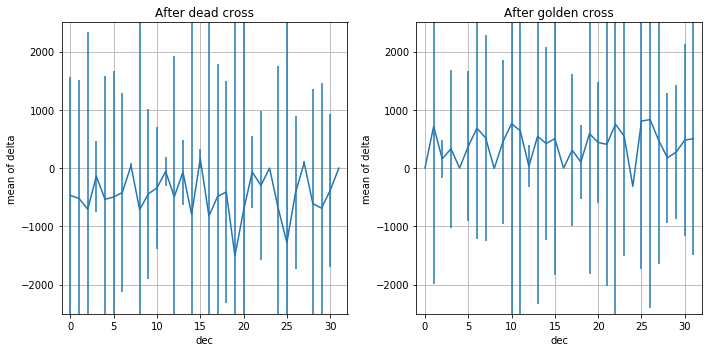

In [16]:
stat_dead = results["stat_dead"]
stat_golden = results["stat_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

### 箱ひげ図

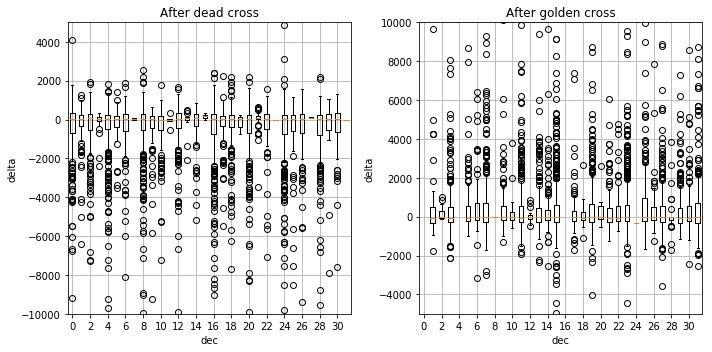

In [17]:
list_ext_dead = results["list_ext_dead"]
list_ext_golden = results["list_ext_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

## N1とN2を変動させて計算
N1とN2はCombinationで生成する。

In [13]:
import time

N_max= 20

st = time.time()
comb_list = []
results_list = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    comb_list.append([x, y])
    results_list.append(main(df[-20000:], x, y, N_dec))
#     break
print(time.time() - st)

101.19856667518616


In [14]:
benefits_list = []
for results in results_list:
    benefits_ = results["benefits"]
    a_k = results["a_k"]
    dead_ = -benefits_[a_k[:, 1] == -1].sum()
    golden_ = benefits_[a_k[:, 1] == 1].sum()
    benefits_list.append([dead_, golden_])

In [15]:
benefits_list

[[-442963, -473131],
 [-341579, -385304],
 [-280193, -321634],
 [-249567, -285252],
 [-218246, -247618],
 [-202043, -215074],
 [-185958, -216240],
 [-169070, -177677],
 [-153928, -166184],
 [-144386, -152471],
 [-137566, -134921],
 [-130542, -133880],
 [-129208, -148754],
 [-130628, -138954],
 [-117990, -143279],
 [-115129, -135488],
 [-93832, -119157],
 [-93015, -130646],
 [-89379, -119772],
 [-172459, -251409],
 [-156372, -216872],
 [-114777, -178875],
 [-80109, -174418],
 [-87969, -160406],
 [-95563, -141737],
 [-76323, -136570],
 [-84199, -130344],
 [-84648, -125822],
 [-76126, -134609],
 [-76074, -123960],
 [-62069, -132864],
 [-58014, -125861],
 [-44333, -98424],
 [-47344, -83934],
 [-41964, -81549],
 [-46069, -78267],
 [-43110, -56485],
 [-64788, -141577],
 [-64827, -138671],
 [-63050, -123420],
 [-69269, -113127],
 [-61675, -112972],
 [-56845, -98401],
 [-43170, -106286],
 [-40886, -106770],
 [-34002, -99396],
 [-33680, -85510],
 [-19094, -79819],
 [-32587, -77497],
 [-34360, -

### ベストな場合

In [16]:
results_list_best = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    results_list_best.append(main_peak(df[-20000:], x, y, N_dec))

In [17]:
benefits_list_best = []
for results in results_list_best:
    benefits_ = results["benefits"]
    a_k = results["a_k"]
    dead_ = -benefits_[a_k[:, 1] == -1].sum()
    golden_ = benefits_[a_k[:, 1] == 1].sum()
    benefits_list_best.append([dead_, golden_])

In [18]:
benefits_list_best

[[-81678, -215091],
 [99669, -24303],
 [233379, 68731],
 [275743, 106593],
 [298529, 156348],
 [337622, 175329],
 [359814, 182943],
 [282573, 200770],
 [287286, 203080],
 [293025, 206768],
 [297220, 228395],
 [296910, 229208],
 [299090, 210083],
 [295350, 212699],
 [305478, 204948],
 [315239, 214501],
 [331301, 233772],
 [327485, 232457],
 [334664, 242399],
 [317855, 174055],
 [379482, 216806],
 [405557, 243859],
 [325806, 241284],
 [335589, 248142],
 [326119, 235695],
 [342433, 245599],
 [342834, 237176],
 [339010, 227249],
 [327465, 217607],
 [324435, 224679],
 [339469, 223664],
 [338949, 226514],
 [350953, 241620],
 [359064, 255253],
 [363260, 257222],
 [356797, 271853],
 [361687, 274084],
 [407519, 228928],
 [328973, 245259],
 [328800, 255631],
 [329430, 253542],
 [331631, 239897],
 [330237, 232680],
 [328286, 221736],
 [323905, 222316],
 [320458, 228097],
 [411287, 222381],
 [418872, 230237],
 [413237, 232983],
 [410346, 234057],
 [427911, 248930],
 [424951, 253654],
 [431089, 258

### 抽出結果の整理

In [19]:
ary = np.zeros((len(comb_list), 6), dtype=int)
for ii in range(len(comb_list)):
    comb_ = comb_list[ii]
    results_ = benefits_list[ii]
    results_best_ = benefits_list_best[ii]
    ary[ii] = np.array([comb_[0], comb_[1], results_[0], results_[1], results_best_[0], results_best_[1]])

In [20]:
benefits_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)
benefits_best_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)

for row in ary:
    benefits_2d[row[0], row[1], 0] = row[2] # dead
    benefits_2d[row[0], row[1], 1] = row[3] # golden
    benefits_best_2d[row[0], row[1], 0] = row[4] # dead
    benefits_best_2d[row[0], row[1], 1] = row[5] # golden

### それぞれの利益の最小値の期待値をイメージプロット

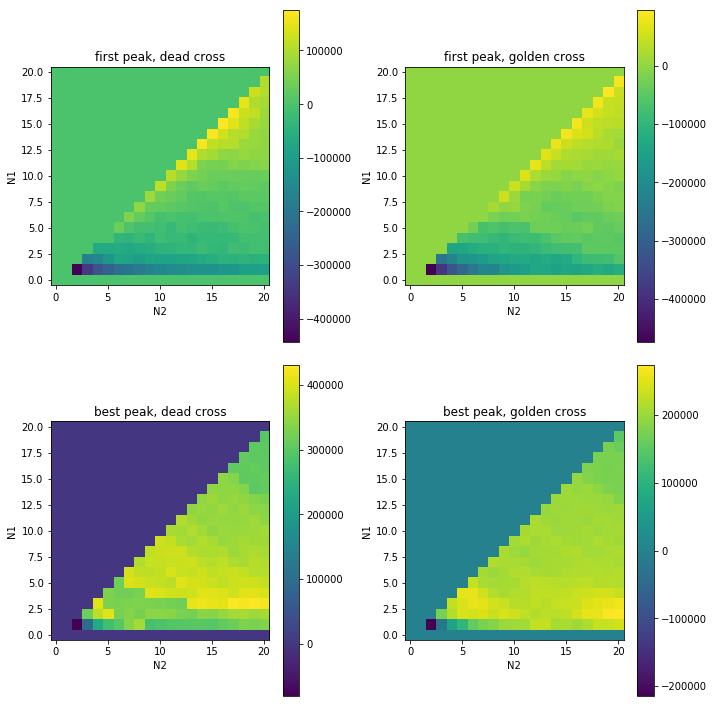

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(benefits_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, dead cross")
plt.colorbar()

plt.subplot(222)
plt.imshow(benefits_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, golden cross")
plt.colorbar()

plt.subplot(223)
plt.imshow(benefits_best_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, dead cross")
plt.colorbar()

plt.subplot(224)
plt.imshow(benefits_best_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, golden cross")
plt.colorbar()

plt.tight_layout()

### dead + golden のイメージプロット

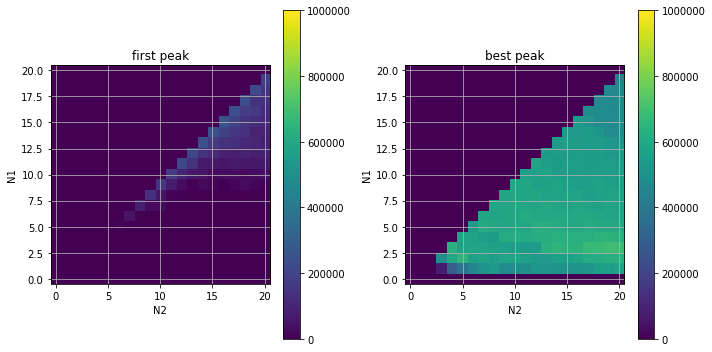

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(benefits_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("first peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, 1e6)
plt.grid(True)

plt.subplot(122)
plt.imshow(benefits_best_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("best peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, 1e6)
plt.grid(True)

plt.tight_layout()
plt.savefig("../images/analysis_of_ohlc(201811)-2.png")

In [23]:
print(np.where(benefits_2d.sum(axis=2)==benefits_2d.sum(axis=2).max()), benefits_2d.sum(axis=2).max())
print(np.where(benefits_best_2d.sum(axis=2)==benefits_best_2d.sum(axis=2).max()), benefits_best_2d.sum(axis=2).max())

(array([15], dtype=int64), array([16], dtype=int64)) 259158
(array([3], dtype=int64), array([19], dtype=int64)) 689235


### 結果の保存

In [25]:
res = dict(
    results_list=results_list, results_list_best=results_list_best,
    N_max=N_max, comb_list=comb_list, benefits_list=benefits_list,
    benefits_list_best=benefits_list_best, benefits_2d=benefits_2d,
    benefits_best_2d=benefits_best_2d, ary=ary
)

with open("../data/analysis_of_ohlc(201807-201811)-2_res.pickle", "wb") as ff:
    pickle.dump(res, ff)

## まとめ
* ２つのEMAの期間を変化させて、利益の違いを解析した。
* 2018/11中では、cross point を越してからのfirst peakで約定した場合にほとんど利益が見込めない。
* また、利益が見込めるN1, N2の組は2018/12/24-2018/12/31と異なる。
    + 2018/12/24-2018/12/31で同じ組み合わせを選択すると4.2万円/BTCとなった。
    + このことから、時期によって適切なN1, N2の組が異なると考えられる。
* Best peakで約定した場合はほとんどのケースで利益が見込めた様子。
* 以上から、EMAだけでは確実に利益を得るスキームを見出すのが難しい可能性が高い。
* 次のスキームとして、特定のOHLCパターンが現れた場合ににだけ売買を実行すればどうだったかを考える。